In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive

Mounted at /content/gdrive
'My Drive'


In [2]:
!curl ipecho.net/plain

104.196.167.216

In [3]:
pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=513fbb63bb5051a923e131fc312fb3ddd6b93dffae7f6a971005eb119c4b503c
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [4]:
%cd /content/gdrive/My\ Drive/Thesis/MovieLens20M

/content/gdrive/My Drive/Thesis/MovieLens20M


In [5]:
import glob
import os
import pandas as pd
import numpy as np

In [ ]:
#import os
#download_path = "Data/"
#every_data = os.listdir(download_path)
#print(every_data)
#for i in every_data:
#    c_path= os.path.join(download_path, i)
#    if i[0] =='_':
#        pass
#    else:
#        new_number = int(i[:-4])+1
#        new_path= os.path.join(download_path, '_{}.mp4'.format(new_number))
#        os.rename(c_path,new_path)
# new_file_name = 
# os.rename(r c_path,r'')
#for i in every_data
#    os.rename(r'file path\OLD file name.file type',r'file path\NEW file name.file type')

In [6]:
def load_name(id):
    csv_path = "movies.csv"
    df= pd.read_csv(csv_path)
    ids = df['movieId']
    return (df.loc[ids == id])['title'].values.tolist()
def load_label(id):
    csv_path = "movies.csv"
    df= pd.read_csv(csv_path)
    ids = df['movieId']
    genres_str = (df.loc[ids == id])['genres'].values.tolist()
    genres = genres_str[0].split('|')
    return genres
def load_all_labels():
    download_path = "Data/"
    ids = os.listdir(download_path)
    all_labels = []
    for id in ids:
        i = int(id.split('.')[0])
        #print(i)
        labels = load_label(i)
        all_labels.extend([l for l in labels if l not in all_labels])
        #print(load_name(i))
    return all_labels

In [7]:
LABELS = load_all_labels()
LABELS.sort()
print(LABELS)

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [ ]:
pip install keras-video-generators

['Comedy', 'Drama', 'Romance']

# **Training stuf.. i guess**

In [8]:
import keras
import cv2 as cv
import glob
import numpy as np
import os
import random
import keras_preprocessing

# author: Patrice Ferlet <patrice.ferlet@smile.fr>
# licence: MIT

class VideoFrameGenerator(keras-video-generators):
    '''
        Video frame generator generates batch of frames from a video directory. 
    '''
    def __init__(self,
                 classes,
                 labels_csv,
                 from_dir,
                 batch_size=8,
                 shape=(224, 224, 3),
                 nbframe=5,
                 shuffle=True,
                 transform:keras.preprocessing.image.ImageDataGenerator=None
                ):
        """
        Create a Video Frame Generator with data augmentation.
        
        Usage example:
        gen = VideoFrameGenerator('./out/videos/',
            batch_size=5,
            nbframe=3,
            transform=keras.preprocessing.image.ImageDataGenerator(rotation_range=5, horizontal_flip=True))
        
        Arguments:
        - from_dir: path to the data directory where resides videos,
            videos should be splitted in directories that are name as labels
        - batch_size: number of videos to generate
        - nbframe: number of frames per video to send
        - shuffle: boolean, shuffle data at start and after each epoch
        - transform: a keras ImageGenerator configured with random transformations
            to apply on each frame. Each video will be processed with the same
            transformation at one time to not break consistence.
        -labels_csv: csv file to video labels.
        """
        
        self.from_dir = from_dir
        self.nbframe = nbframe
        self.batch_size = batch_size
        self.target_shape = shape
        self.shuffle = shuffle
        self.transform = transform
        self.labels_csv = labels_csv
        
        # the list of classes, built in __list_all_files
        self.classes = classes
        self.files = []
        self.data = []
        
        # prepare the list
        self.__filecount = 0
        self.__list_all_files()
    
        
    def __len__(self):
        """ Length of the generator
        Warning: it gives the number of loop to do, not the number of files or
        frames. The result is number_of_video/batch_size. You can use it as
        `step_per_epoch` or `validation_step` for `model.fit_generator` parameters.
        """
        return self.__filecount//self.batch_size
    
    def __getitem__(self, index):
        """ Generator needed method - return a batch of `batch_size` video
        block with `self.nbframe` for each
        """
        indexes = self.data[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_aug(indexes)
        return X, Y
    
    def on_epoch_end(self):
        """ When epoch has finished, random shuffle images in memory """
        if self.shuffle:
            random.shuffle(self.data)
    
    def __list_all_files(self):
        """ List and inject images in memory """
        #self.classes = glob.glob(os.path.join(self.from_dir, '*'))
        #self.classes = [os.path.basename(c) for c in self.classes]
        #self.__filecount = len(glob.glob(os.path.join(self.from_dir, '*/*')))
        self.__filecount = len(os.listdir(self.from_dir))
        i = 1
        print("Inject frames in memory, could take a while...")
        
        files = os.listdir(self.from_dir)
        for file in files:
            print('\rProcessing file %d/%d' % (i, self.__filecount), end='  ...')
            i+=1
            classnames = self.__load_labels(file)
            for classname in classnames:
                self.__openframe(classname, os.path.join(self.from_dir,file))
                
        if self.shuffle:
            random.shuffle(self.data)
    
    def __load_labels(self,file):
        
        id = int(file[:-4])
        df= pd.read_csv(self.labels_csv)
        ids = df['movieId']
        genres_str = (df.loc[ids == id])['genres'].values.tolist()
        genres = genres_str[0].split('|')
        return genres    
        
    def __openframe(self, classname, file):
        """Append ORIGNALS frames in memory, transformations are made on the fly"""
        frames = []
        vid = cv.VideoCapture(file)
        while True:
            grabbed, frame = vid.read()
            if not grabbed:
                break
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frame = cv.resize(frame, self.target_shape[:2])    
            frames.append(frame)
        
        step = len(frames)//self.nbframe
        frames = frames[::step]
        if len(frames) >= self.nbframe:
            frames = frames[:self.nbframe]
        
        # add frames in memory
        if len(frames) == self.nbframe:
            self.data.append((classname, frames))
        else:
            print('\n%s/%s has not enough frames ==> %d' % (classname, file, len(frames)))
            
    def __data_aug(self, batch):
        """ Make random transformation based on ImageGenerator arguments"""
        T = None
        if self.transform:
            T = self.transform.get_random_transform(self.target_shape[:2])
        
        X, Y = [], []
        for y, images in batch:
            Y.append(self.classes.index(y)) # label
            x = []
            for img in images:
                if T:
                    x.append(self.transform.apply_transform(img, T))
                else:
                    x.append(img)
                    
            X.append(x)

        return np.array(X), keras.utils.to_categorical(Y, num_classes=len(self.classes))

In [9]:

import os
import glob
import keras

In [10]:
# some global params
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 50
BS = 8
glob_pattern='Data/'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=LABELS, 
    from_dir="Data/",
    labels_csv = "movies.csv",
    nbframe=NBFRAME,
    shuffle=True,
    batch_size=BS,
    shape=SIZE,
    transform=data_aug)

Inject frames in memory, could take a while...
Processing file 465/465  ...

In [ ]:
print(os.path.join("Data/","1.mp4"))

Data/1.mp4


In [13]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
    model.add(GRU(64))    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [17]:
from keras.layers import Conv2D, BatchNormalization,MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [18]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(LABELS))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

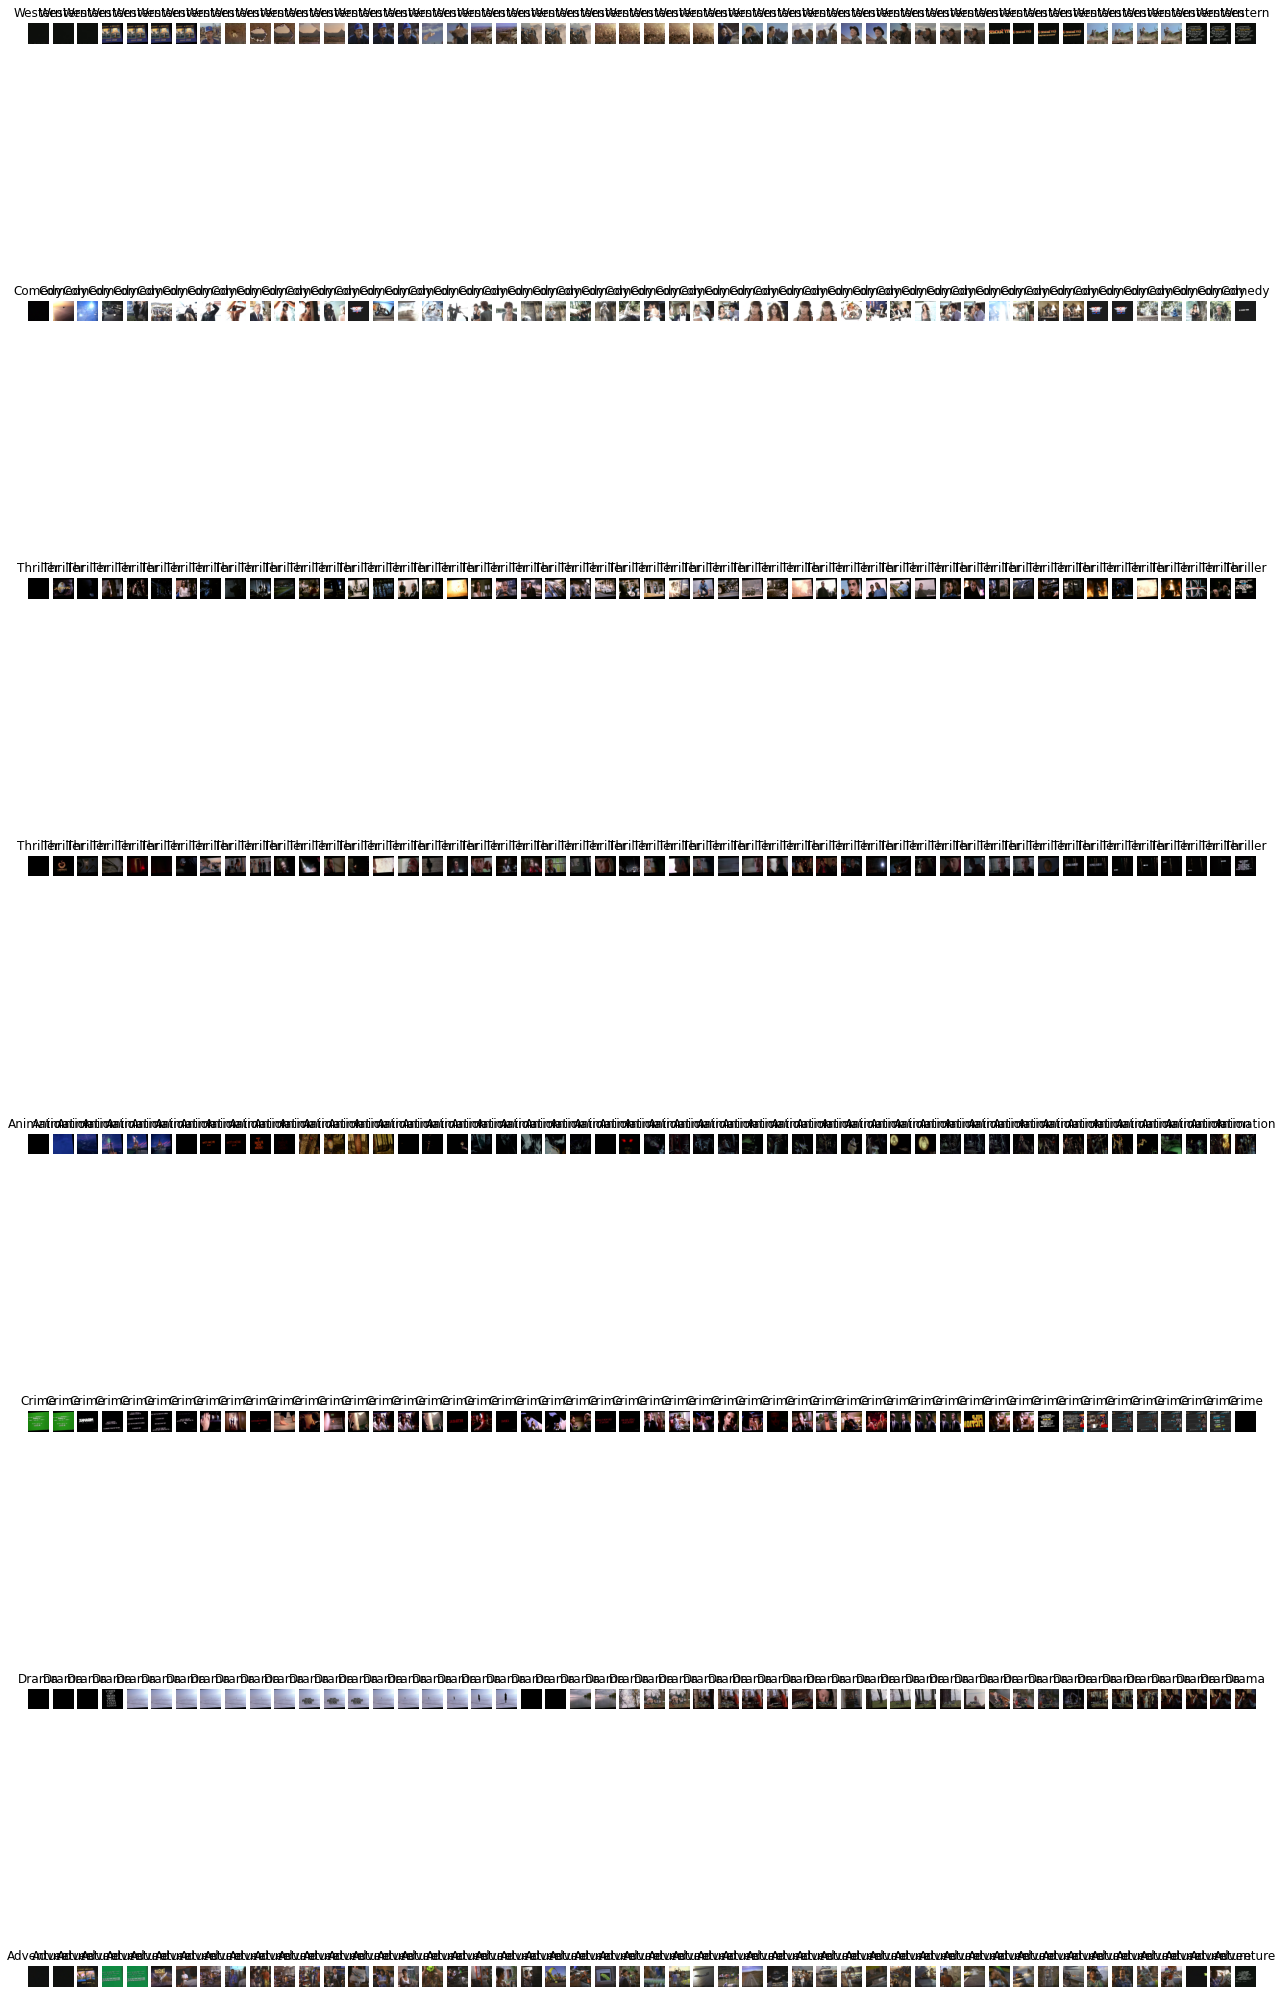

In [19]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [26]:
EPOCHS=50# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 2.7486 - acc: 0.1422  WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/callbacks.py", line 1330, in _get_file_path
    file_path = self.filepath.format(epoch=epoch + 1, **logs)
KeyError: 'val_loss'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-9b820c6fa1c4>", line 14, in <module>
    callbacks=callbacks
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1829, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper


TypeError: ignored